In [1]:
from main import create_packets, sort_packets, Packet, PacketOutput, LCFS_S, LCFS_W, ProposedPolicy, get_outputs_by_source

In [2]:
policies = [
    ("proposed_policy", ProposedPolicy()),
    ("lcfs_s", LCFS_S()),
    ("lcfs_w", LCFS_W())
]

In [30]:
packets = sort_packets(
    create_packets(max_arrival_time=100, source=0, arrival_rate=1, service_time_mean=1), 
    create_packets(max_arrival_time=100, source=1, arrival_rate=1, service_time_mean=1),
)

In [31]:
outputs = ProposedPolicy().simulate(packets)

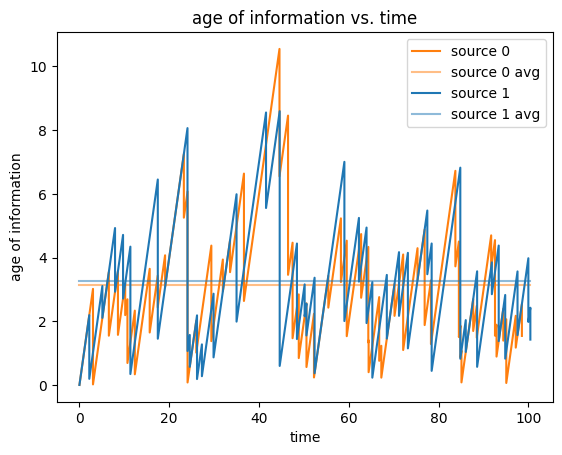

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

from typing import NamedTuple

class AoiUpdate(NamedTuple):
    time: float # when this age of information was generated
    age: float # the age of information
    

def save_packets():
    pass
    
def save_output_packets():
    pass

def calculate_average_age_information(outputs: list[PacketOutput], source: int) -> float:
    updates = get_age_of_information_updates(outputs, source)

    total = 0
    total_delta_time = 0
    
    for i in range(1, len(updates)-1, 2):
        prev_update = updates[i-1]
        update = updates[i]
    
        delta_time = update.time - prev_update.time
        total += ((update.age + prev_update.age)/2) * delta_time
        total_delta_time += delta_time
    
    return total / total_delta_time

def get_age_of_information_updates(outputs: list[PacketOutput], source: int) -> list[AoiUpdate]:
    updates = [AoiUpdate(time=0, age=0)] # simulation time, age of information
    outputs = get_outputs_by_source(outputs, source)
    
    prev = PacketOutput(arrival_time=0, service_end_time=0, source=-1) # dummy packet
    for packet in outputs:
        time = packet.service_end_time # when the age of information changes
        updates.append(AoiUpdate(time=time, age=prev.service_end_time - prev.arrival_time + (packet.service_end_time - prev.service_end_time)))
        updates.append(AoiUpdate(time=time, age=packet.service_end_time - packet.arrival_time))
        prev = packet

    return updates

    
def plot_age_of_information(outputs: list[PacketOutput], sources: list[int], plot_average=False):
    colors = ['tab:orange', 'tab:blue']
    max_time = max(output.service_end_time for output in outputs)
    
    for source in sources:
        updates = get_age_of_information_updates(outputs, source)
        
        if len(updates) < 1:
            continue
        
        plt.plot([x for x, _ in updates], [y for _, y in updates], label=f'source {source}', c=colors[source], alpha=1)
        
        if plot_average:
            avg = calculate_average_age_information(outputs, source)
            plt.plot((0, max_time), (avg, avg), label=f'source {source} avg', c=colors[source], alpha=0.5)
            

    plt.title('age of information vs. time')
    plt.xlabel('time')
    plt.ylabel('age of information')
    plt.legend()
    plt.show()
    
plot_age_of_information(outputs, sources=[0, 1], plot_average=True)

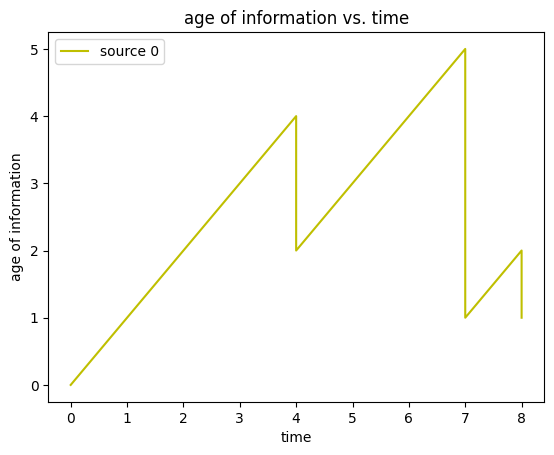

In [38]:
dummy_output = [
    PacketOutput(source=0, arrival_time=2, service_end_time=4),
    PacketOutput(source=0, arrival_time=6, service_end_time=7),
    PacketOutput(source=0, arrival_time=7, service_end_time=8),
]
plot_age_of_information(dummy_output, sources=[0])

In [27]:
updates = get_age_of_information_updates(dummy_output, source=0)
updates

[AoiUpdate(time=0, age=0),
 AoiUpdate(time=4, age=4),
 AoiUpdate(time=4, age=2),
 AoiUpdate(time=7, age=5),
 AoiUpdate(time=7, age=1),
 AoiUpdate(time=8, age=2),
 AoiUpdate(time=8, age=1)]

2.5